<a href="https://colab.research.google.com/github/youngho-kwon-class/ml-edu-lab/blob/main/gan/gan-cnn-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]


Epoch 1/20 | D Loss: 0.1350 | G Loss: 2.3815
Epoch 2/20 | D Loss: 0.1615 | G Loss: 4.7725
Epoch 3/20 | D Loss: 0.1405 | G Loss: 4.8212
Epoch 4/20 | D Loss: 0.6290 | G Loss: 2.5608
Epoch 5/20 | D Loss: 0.6018 | G Loss: 2.2287
Epoch 6/20 | D Loss: 0.8602 | G Loss: 1.4422
Epoch 7/20 | D Loss: 1.4377 | G Loss: 1.6547
Epoch 8/20 | D Loss: 0.4269 | G Loss: 2.2543
Epoch 9/20 | D Loss: 1.3517 | G Loss: 0.8174
Epoch 10/20 | D Loss: 0.5083 | G Loss: 1.7049
Epoch 11/20 | D Loss: 0.1928 | G Loss: 3.5093
Epoch 12/20 | D Loss: 0.5158 | G Loss: 2.0113
Epoch 13/20 | D Loss: 0.2152 | G Loss: 2.9090
Epoch 14/20 | D Loss: 0.3391 | G Loss: 3.6752
Epoch 15/20 | D Loss: 0.1269 | G Loss: 6.4122
Epoch 16/20 | D Loss: 0.1068 | G Loss: 4.3239
Epoch 17/20 | D Loss: 0.1493 | G Loss: 4.8000
Epoch 18/20 | D Loss: 0.0894 | G Loss: 3.7771
Epoch 19/20 | D Loss: 0.0356 | G Loss: 5.2181
Epoch 20/20 | D Loss: 0.1944 | G Loss: 2.6767


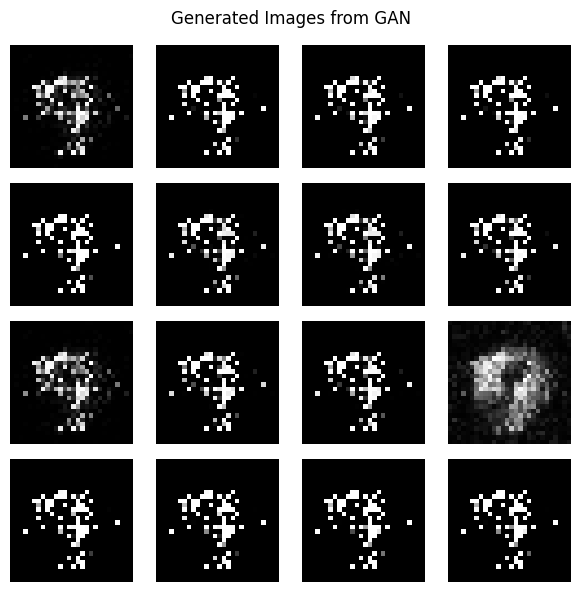

In [1]:
#1.라이브러리 정의

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#2.MNIST 데이터셋 load

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1] 범위로 정규화
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

 #3. Generator & Discriminator 정의

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

#4.손실함수와 옵티마이저 정의
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

#5.학습 루프

epochs = 20

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # 진짜/가짜 라벨
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Generator
        # ---------------------
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        real_loss = criterion(discriminator(real_imgs), real)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

#6.생성 이미지 시각화

generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gen_imgs = generator(z).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(16):
        axes[i//4, i%4].imshow(gen_imgs[i].squeeze(), cmap='gray')
        axes[i//4, i%4].axis('off')
    plt.suptitle("Generated Images from GAN")
    plt.tight_layout()
    plt.show()




